# Задача

Проанализируйте клиентов регионального банка и сегментируйте пользователей по количеству потребляемых продуктов.

# Описание данных

Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

Колонки:

- `userid` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `City` — город,
- `Gender` — пол,
- `Age` — возраст,
- `Objects` — количество объектов в собственности,
- `Balance` — баланс на счёте,
- `Products` — количество продуктов, которыми пользуется клиент,
- `CreditCard` — есть ли кредитная карта,
- `Loyalty` — активный клиент,
- `estimated_salary` — заработная плата клиента,
- `Churn` — ушёл или нет.

## Исследовательский анализ данных

### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import scipy.stats
from scipy.stats import mannwhitneyu

sns.set_style("dark") 
sns.set_palette("mako")
sns.set(rc = {'figure.figsize':(10,5)})


### Загрузка и ознакомление с данными

In [2]:
try:
    df = pd.read_csv('/datasets/bank_dataset.csv')
except FileNotFoundError:
    df = pd.read_csv('/Users/nikita/Downloads/bank_dataset.csv')

In [3]:
df.sample(5)

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
9597,15773177,509,Ярославль,М,26,10,NaN,2,1,1,6177.83,0
7044,15781223,678,Ярославль,М,26,3,NaN,2,1,0,4989.33,0
3244,15689672,631,Ростов Великий,Ж,32,2,146810.99,2,1,1,180990.29,0
8145,15751640,850,Ярославль,Ж,37,9,NaN,1,0,0,100101.06,0
5782,15714250,669,Рыбинск,Ж,33,8,NaN,2,0,1,128538.05,0


### Предобработка данных

In [4]:
df.columns = df.columns.str.lower()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   city              10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   objects           10000 non-null  int64  
 6   balance           6383 non-null   float64
 7   products          10000 non-null  int64  
 8   creditcard        10000 non-null  int64  
 9   loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [5]:
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

userid - 0%
score - 0%
city - 0%
gender - 0%
age - 0%
objects - 0%
balance - 36%
products - 0%
creditcard - 0%
loyalty - 0%
estimated_salary - 0%
churn - 0%


In [6]:
df.duplicated().sum()

0

Данные проверены на дубликаты. Также определено, что данные о балансе для 36% пользователей отсутсвуют. На данном этапе с этими пропусками работать не будем. Так как это может проявиться лишь позже, после разделение на группы.

In [7]:
nan_df = df[df['balance'].isna()].head()
#nan_df.query('city == "Ярославль"')
for col in nan_df.query('city == "Ярославль"').columns:
    pct_missing = np.mean(df.query('city == "Ярославль"')[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

userid - 0%
score - 0%
city - 0%
gender - 0%
age - 0%
objects - 0%
balance - 48%
products - 0%
creditcard - 0%
loyalty - 0%
estimated_salary - 0%
churn - 0%


In [8]:
for col in nan_df.query('city != "Ярославль"').columns:
    pct_missing = np.mean(df.query('city != "Ярославль"')[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

userid - 0%
score - 0%
city - 0%
gender - 0%
age - 0%
objects - 0%
balance - 24%
products - 0%
creditcard - 0%
loyalty - 0%
estimated_salary - 0%
churn - 0%


Гипотеза - работники центральных отделений не заполняют данные по балансу клиентов на время выгрузки

### Изучение данных

In [9]:
df.drop('userid', axis = 1).describe(include = 'all')

,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn
count,10000.000000,10000,10000,10000.000000,10000.000000,6383.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
unique,NaN,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Ярославль,М,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,5014,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,650.528800,NaN,NaN,38.921800,5.012800,119827.493793,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,NaN,NaN,10.487806,2.892174,30095.056462,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,NaN,NaN,18.000000,0.000000,3768.690000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,NaN,NaN,32.000000,3.000000,100181.975000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,NaN,NaN,37.000000,5.000000,119839.690000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,NaN,NaN,44.000000,7.000000,139512.290000,2.000000,1.00000,1.000000,149388.247500,0.000000


В таблице можно увидеть численные значения различных параметров.
Кредитный рейтинг - среднее и медианное значение очень близки, данные близки к нормальным. Минимальное значение - 350, максимальное - 850
Возраст - от 18 до 92 лет, средний возраст клиента 39 лет
В среднем пользователи банка имеют 5 объектов в собственности
Баланс среднего клиента - 119 тысяч рублей, эти данные также соотносятся с медианными - ра спределение нормальное.
Клиенты в большинстве используют лишь один банковский продукт
70% клиентов имеют кредитную карту.
Средняя и медианная заработная плата - 100 тысяч рублей.

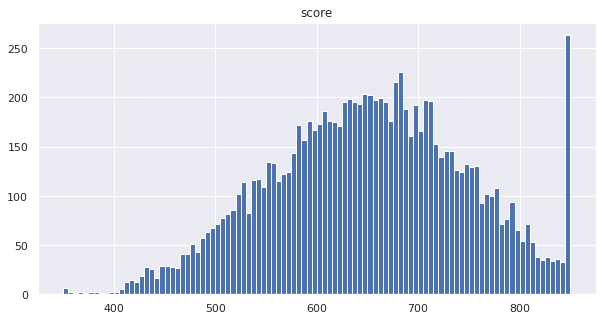

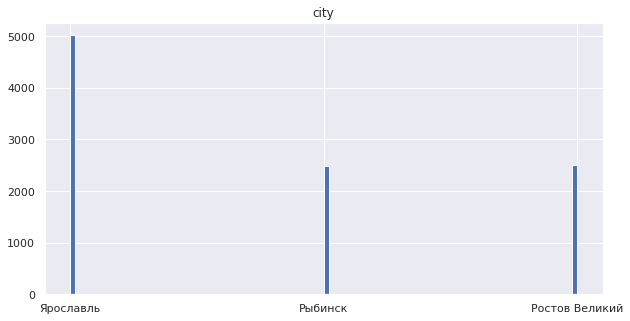

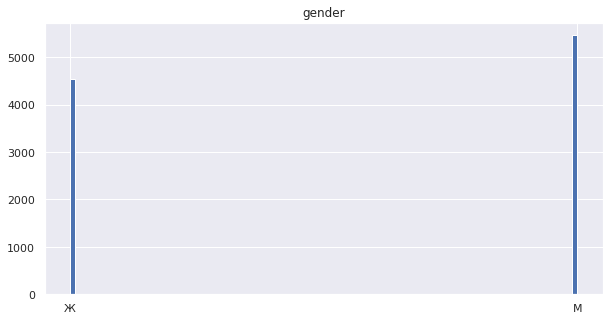

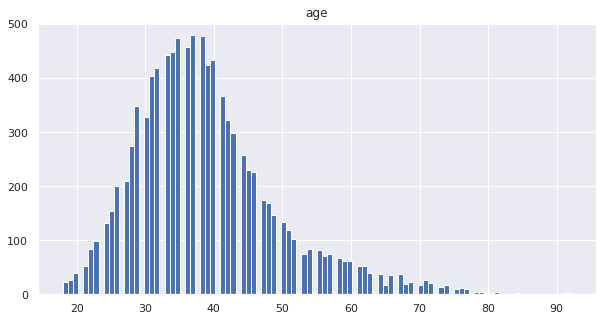

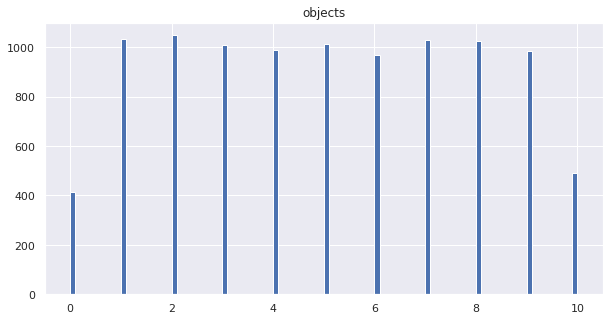

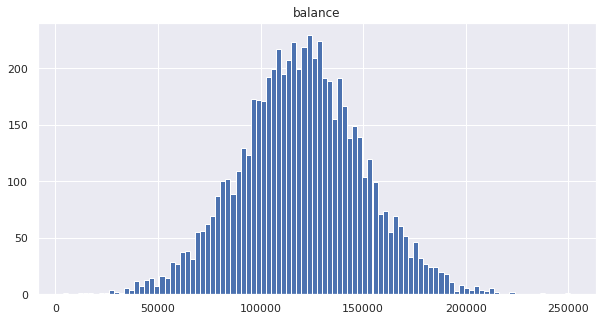

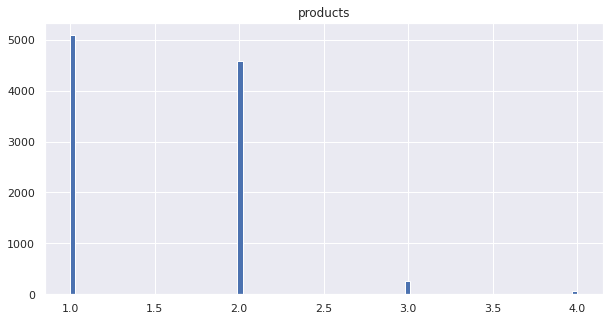

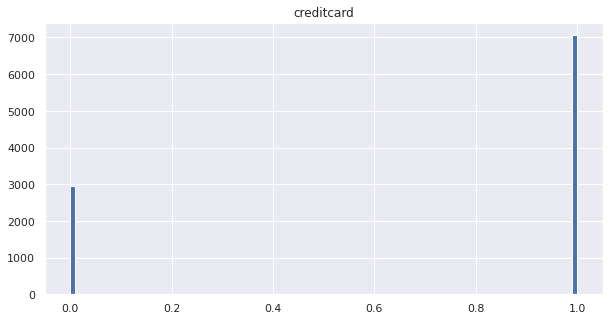

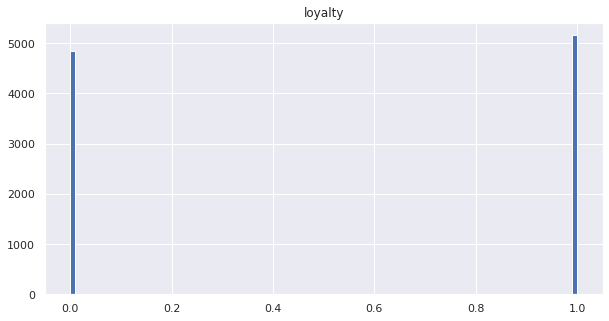

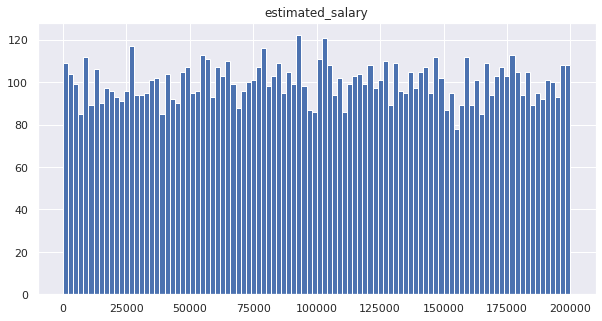

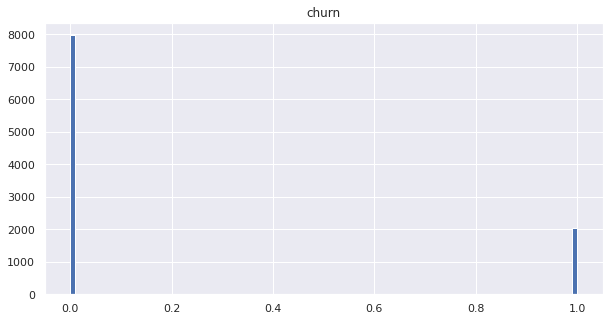

In [10]:
for col in df.drop('userid', axis = 1):
    df[col].hist(bins = 100)
    plt.title(col)
    plt.show()

Обращаясь к графикам:
1. Наблюдаеся всплеск "идеальных" клиентов с наивысшим рейтингом
2. Возраст - от 18 до 92 лет, средний возраст клиента 39 лет
3. Филиалы в Ярсолавле самые многочисленные
4. В большей части клиенты банка - мужчины
5. По возрасты клиенты распределны нормально
6. Пользователи владеют до 10 объектами, рспределены равномерно. В среднем пользователи банка имеют 5 объектов в собственности.
7. Данные о балансе распределны нормально. Баланс среднего клиента - 119 тысяч рублей, эти данные также соотносятся с медианными.
8. В основном пользователи пользуются лишь одним продуктом
9. 70% клиентов используют кредитную карту
10. Зарплаты распределены равномерно
11. Полный возвраст есть лишь у 20% клиентов


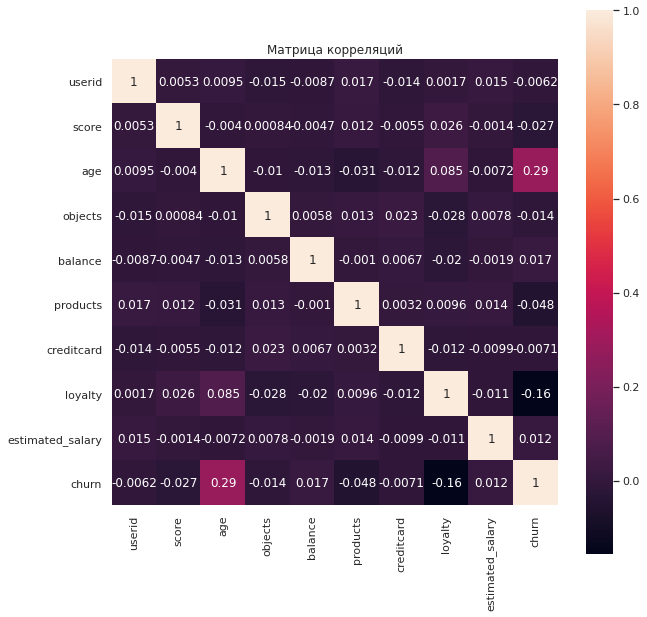

In [11]:
sns.set(rc = {'figure.figsize':(10,10)})
cm = df.corr()
fig, ax = plt.subplots()


sns.heatmap(cm, annot = True, square = True) 
plt.title('Матрица корреляций')
plt.show()

Наиболее коррелирующие значения - возраст с показателем возврата кредита

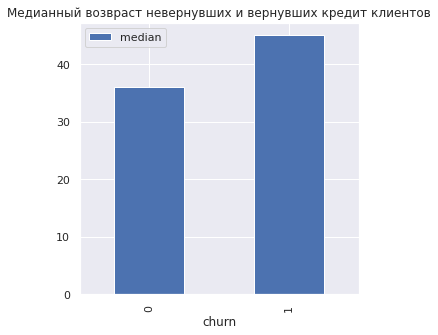

,mean,median,count
churn,,,
0,37.408389,36,7963
1,44.837997,45,2037


In [12]:
sns.set(rc = {'figure.figsize':(5,5)})
corr_df = df.pivot_table( index = 'churn', values = 'age', aggfunc = ['mean', 'median','count'])
corr_df.columns = ['mean','median','count']
corr_df.sort_values('median', ascending = False)
corr_df.plot(kind = 'bar',y = 'median')
plt.title('Медианный возвраст невернувших и вернувших кредит клиентов')
plt.show()
corr_df

Проверив наиболее выраженный признак, можно заметить, что вернувшие кредит клиенты в среднем старше почти на 10 лет, т.е. относятся к разным поколениям.

### Выводы

После проведения исследовательского анализа данных можно сделать следующие выводы о клиентах банка:
1. Наблюдаеся всплеск "идеальных" клиентов с наивысшим рейтингом
2. Филиалы в Ярсолавле самые многочисленные
3. В большей части клиенты банка - мужчины
4. По возрасты клиенты распределны нормально
5. Пользователи владеют до 10 объектами, рспределены равномерно
6. Данные о балансе распределны нормально
7. В основном пользователи пользуются лишь одним продуктом
8. 70% клиентов используют кредитную карту
9. Зарплаты распределены равномерно
10. Полный возвраст есть лишь у 20% клиентов

Проверив наиболее коррелирующий признак можно сделать вывод, что возвращающие клиенты в среднем на 10 лет старше.

## Сегментирование пользователей на основе данных о количестве потребляемых продуктов

In [13]:
product_df = df.groupby('products').agg({'userid':'count', 'score':'median', 'age':'mean',  
                                        'objects':'mean', 'balance':'median',  
                                        'creditcard':'mean', 'loyalty':'mean',  
                                        'estimated_salary':'median', 'churn':'mean'}).reset_index()
product_df

,products,userid,score,age,objects,balance,creditcard,loyalty,estimated_salary,churn
0,1,5084,651,39.673092,4.974626,119919.120,0.703777,0.504131,99226.830,0.277144
1,2,4590,653,37.753595,5.051852,119762.245,0.707190,0.532898,100738.855,0.075817
2,3,266,650,43.195489,5.003759,118118.190,0.714286,0.424812,101046.885,0.827068
3,4,60,643,45.683333,5.300000,120968.270,0.683333,0.483333,112163.105,1.000000


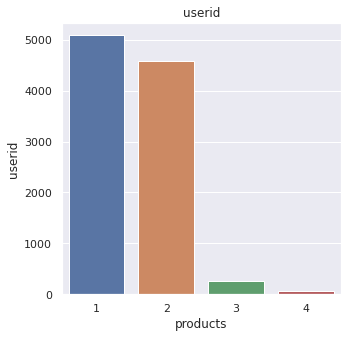

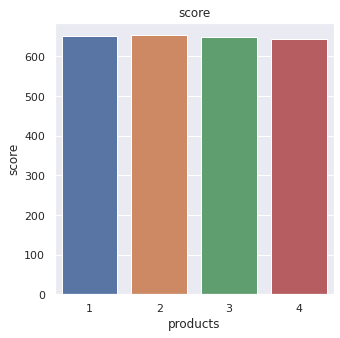

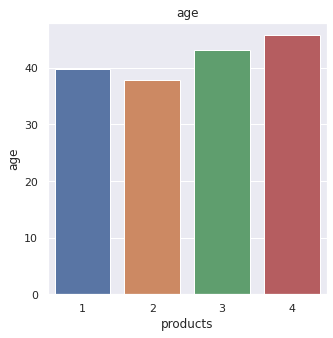

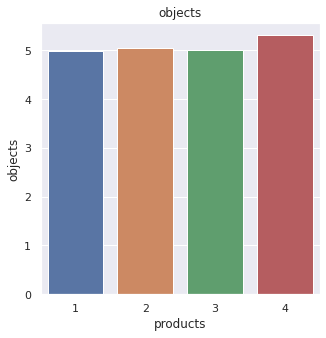

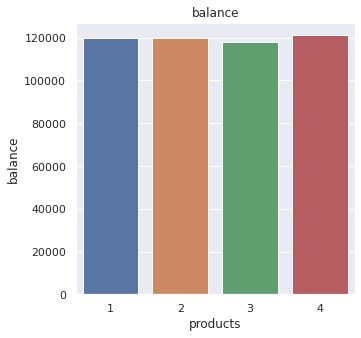

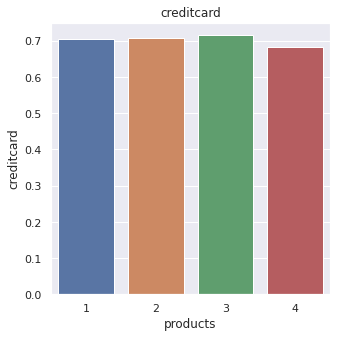

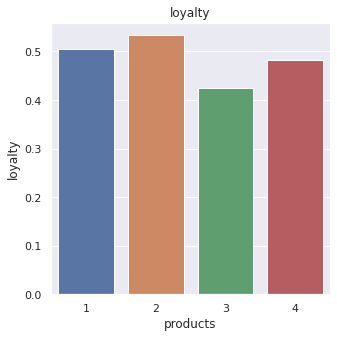

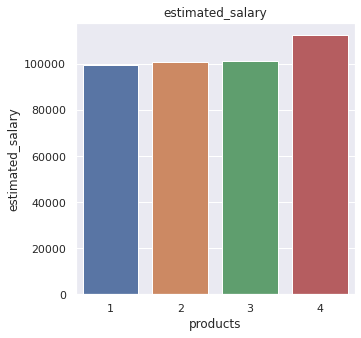

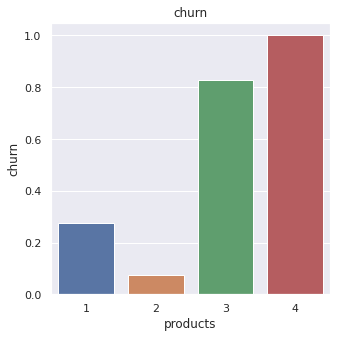

In [14]:

for col in product_df.drop('products', axis = 1):
    sns.barplot(data = product_df, x = product_df['products'], y = product_df[col])
    plt.title(col)
    plt.show()
    

In [15]:
#df.groupby('city').agg({'userid':'count', 'score':'median', 'age':'mean',  
#                                        'objects':'mean', 'balance':'median',  
#                                        'creditcard':'mean', 'loyalty':'mean',  
#                                        'estimated_salary':'median', 'churn':'mean'}).T

In [16]:
#df.groupby('churn').agg({'userid':'count', 'score':'median', 'age':'mean',  
#                                        'objects':'mean', 'balance':'median',  
#                                        'creditcard':'mean', 'loyalty':'mean',  
#                                        'estimated_salary':'median', 'churn':'mean'}).T

In [17]:
#df.groupby('gender').agg({'userid':'count', 'score':'median', 'age':'mean',  
#                                        'objects':'mean', 'balance':'median',  
#                                        'creditcard':'mean', 'loyalty':'mean',  
#                                        'estimated_salary':'median', 'churn':'mean'}).T

Рассмотрим каждый сегмент по отдельности

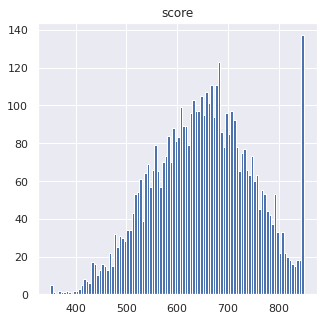

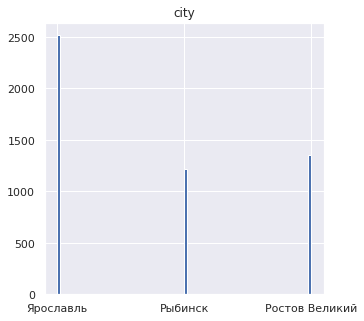

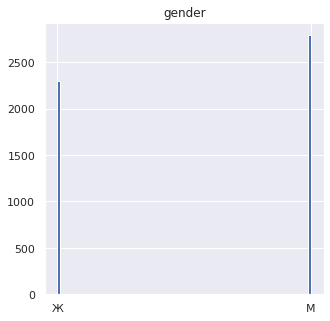

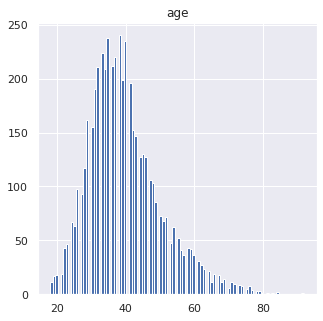

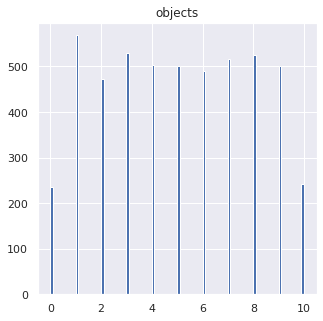

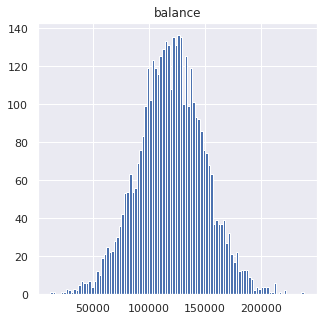

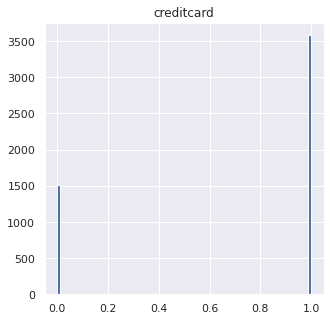

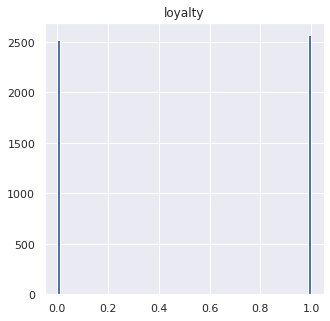

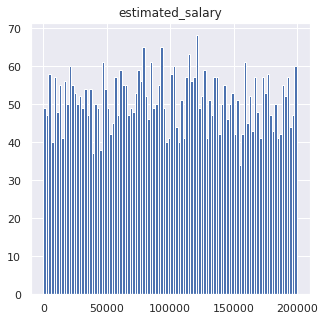

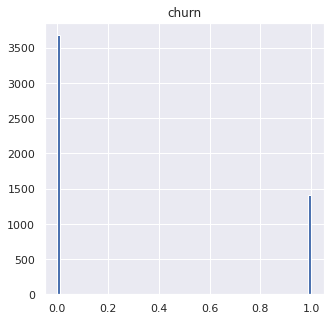

In [16]:
#print(df_1.agg('median'))
df_1 = df.query('products==1').drop(['userid','products'], axis = 1)
for col in df_1:
    df_1[col].hist(bins = 100)
    plt.title(col)
    plt.show()


- Кредитный рейтинг - распределен нормально со смещением вправо, большая часть клиентов имеет рейтинг выше 650.
- Город - наибольшая группа проживает в городе Ярославль
- Пол - Мужчины в этой категории более многочисленны
- Возраст - Распределен нормально, средний возраст 38 лет
- Объектты владения - в среднем 5
- Баланс - распределен нормально, с медианным значением порядка 120 тысяч рублей
- Наличие кредитной карты - значительная часть пользователей имеет кредитную карту
- Лояльность - по уровню лояльности этот сегмент не имеет ярко выраженной особенности
- Ожидаемая зарплата - распределена равномерно, медианный уровень 99 тысяч рублей
- Возврат - большая часть имеет непогашенный кредит

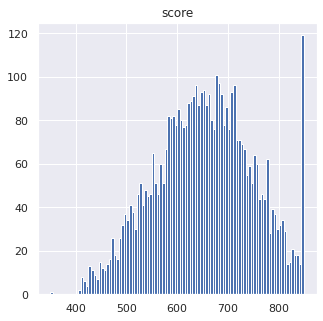

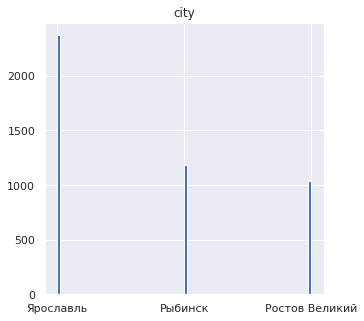

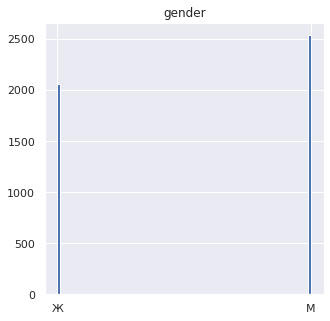

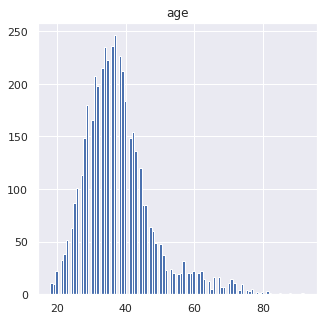

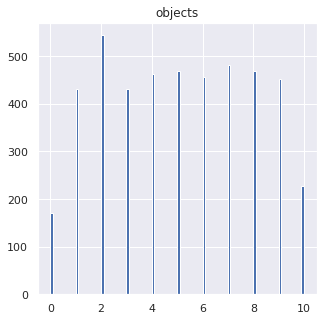

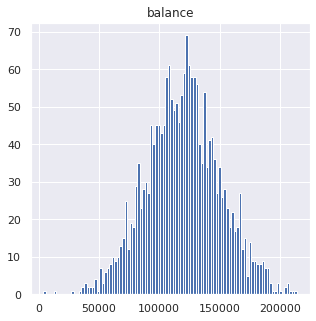

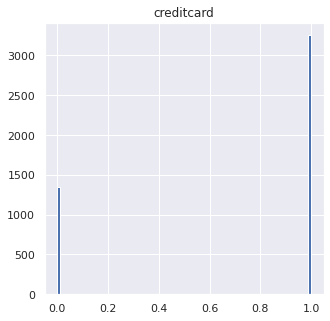

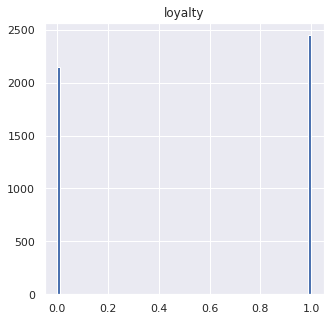

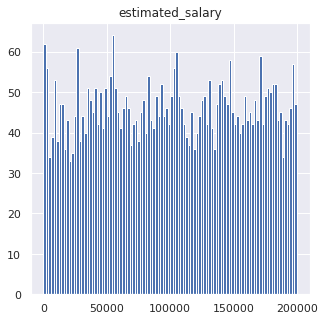

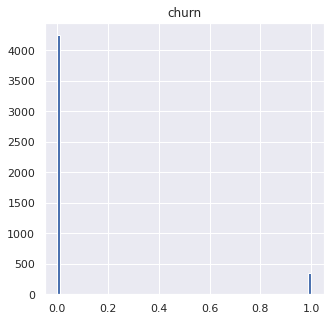

In [17]:
df_2 = df.query('products==2').drop(['userid','products'], axis = 1)
for col in df_1:
    df_2[col].hist(bins = 100)
    plt.title(col)
    plt.show()

In [18]:
print(df_3.agg('median'))

NameError: name 'df_3' is not defined

- Кредитный рейтинг - распределен нормально со смещением вправо, большая часть клиентов имеет рейтинг выше 650.
- Город - наибольшая группа проживает в городе Ярославль
- Пол - Мужчины в этой категории более многочисленны
- Возраст - Распределен нормально, средний возраст 42 года
- Объектты владения - в среднем 5, наблюдается всплеск количесвта владельцев двумя объектами собвтенности
- Баланс - распределен нормально, с медианным значением порядка 118 тысяч рублей
- Наличие кредитной карты - значительная часть пользователей имеет кредитную карту
- Лояльность - по уровню лояльности этот сегмент имеет неявно выраженную лояльность
- Ожидаемая зарплата - распределена равномерно, медианный уровень 99 тысяч рублей
- Возврат - большая часть имеет непогашенный кредит

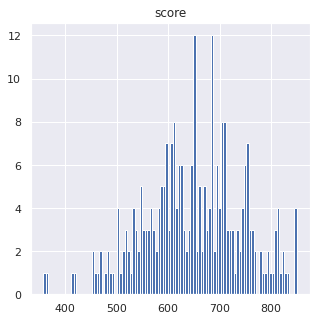

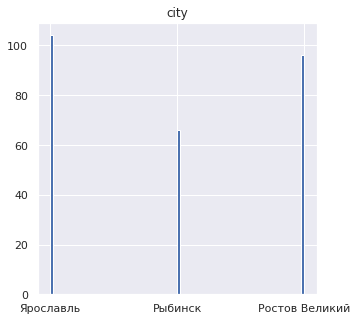

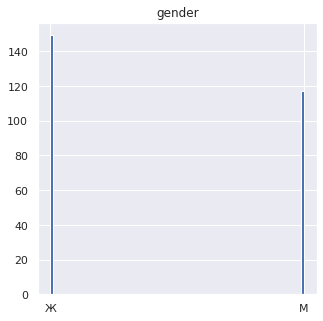

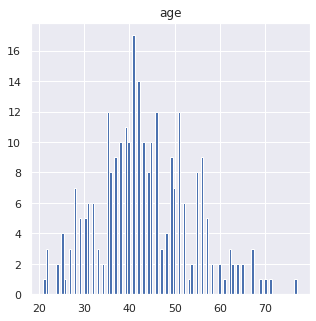

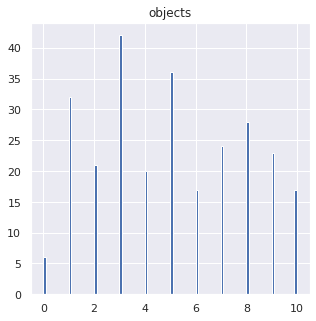

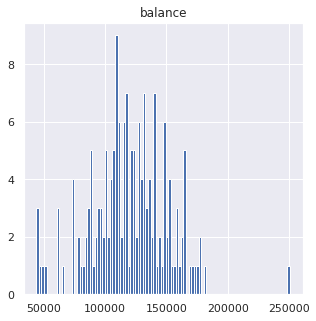

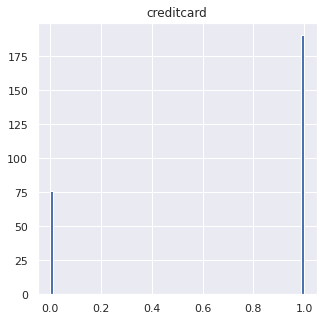

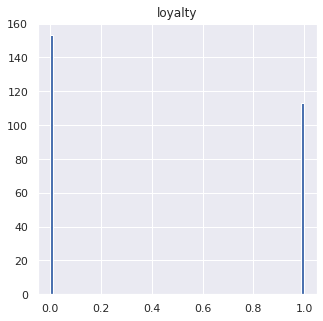

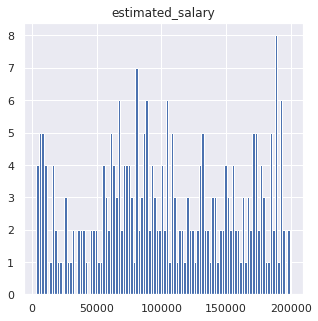

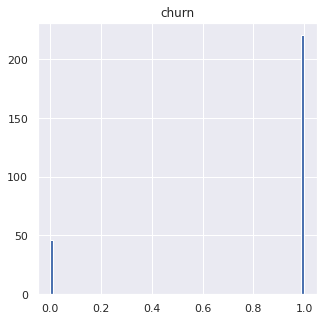

In [19]:
df_3 = df.query('products==3').drop(['userid','products'], axis = 1)
for col in df_1:
    df_3[col].hist(bins = 100)
    plt.title(col)
    plt.show()

In [20]:
print(df_3.agg('median'))

score                  650.000
age                     42.000
objects                  5.000
balance             118118.190
creditcard               1.000
loyalty                  0.000
estimated_salary    101046.885
churn                    1.000
dtype: float64


- Кредитный рейтинг - распределен нормально со смещением вправо, большая часть клиентов имеет рейтинг выше 650. Нет выраженного всплеска в наивысшем рейтинге.
- Город - практически равное количество людей живет в Ярославле и Ростове
- Пол - женщины в этой категории более многочисленны
- Возраст - Распределен нормально, средний возраст 42 года
- Объектты владения - в среднем 5, наблюдается всплеск количесвта владельцев тремя объектами собвтенности
- Баланс - распределен нормально, с медианным значением порядка 118 тысяч рублей. Так как группа менее многочислена - график более дискретный. 
- Наличие кредитной карты - значительная часть пользователей имеет кредитную карту
- Лояльность - по уровню лояльности этот сегмент более нелоялен
- Ожидаемая зарплата - распределена равномерно, медианный уровень 101 тысяча рублей
- Возврат - большая часть имеет погашенный кредит

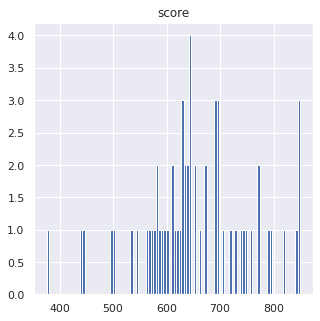

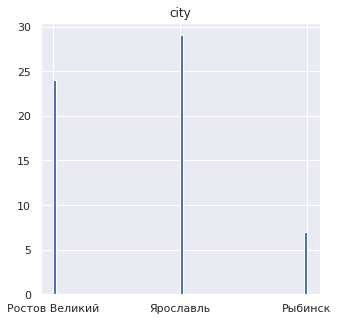

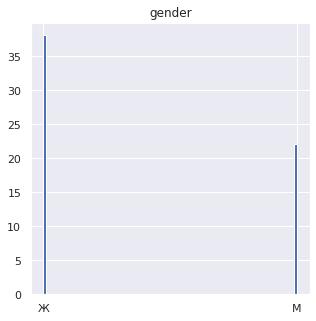

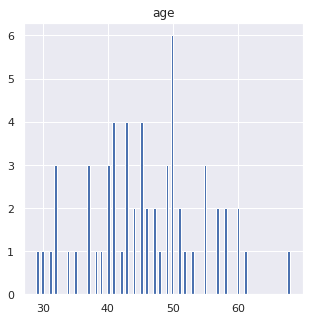

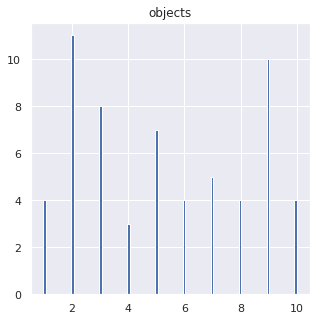

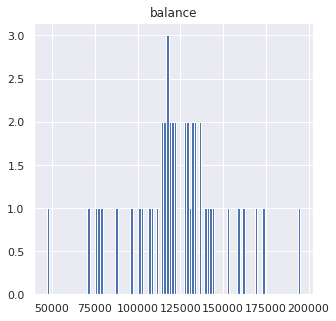

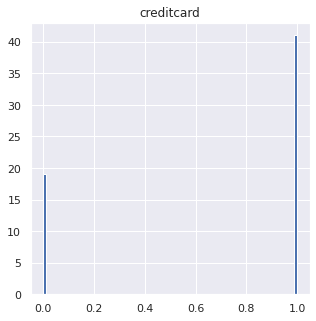

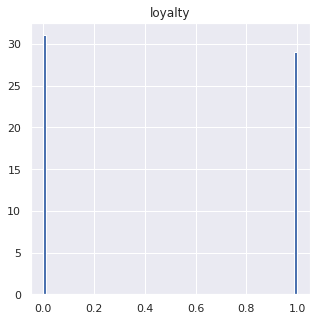

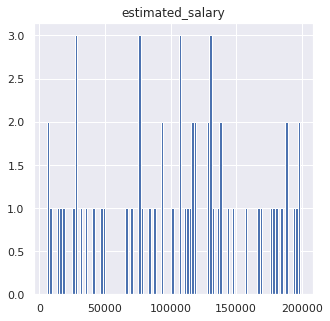

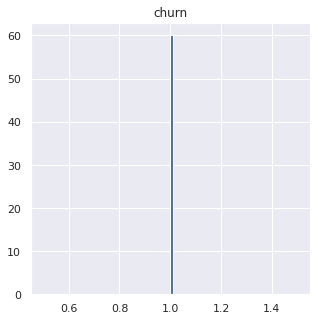

In [21]:
df_4 = df.query('products==4').drop(['userid','products'], axis = 1)
for col in df_1:
    df_4[col].hist(bins = 100)
    plt.title(col)
    plt.show()

In [22]:
print(df_4.agg('median'))

score                  643.000
age                     45.000
objects                  5.000
balance             120968.270
creditcard               1.000
loyalty                  0.000
estimated_salary    112163.105
churn                    1.000
dtype: float64


- Кредитный рейтинг - медианный рейтинг незначительно ниже, однако ввиду меньшего количества пользователей распределние определить трудно
- Город - практически равное количество людей живет в Ярославле и Ростове
- Пол - женщины в этой категории более многочисленны
- Возраст - Распределен нормально, средний возраст 45 лет и по количеству смещен вправа
- Объекты владения - в среднем 5, наблюдается всплеск количесвтва владельцев двумя объектами собвтенности
- Баланс - распределен нормально, с медианным значением порядка 120 тысяч рублей. Так как группа менее многочислена - график более дискретный. Смещен вправо
- Наличие кредитной карты - значительная часть пользователей имеет кредитную карту
- Лояльность - по уровню лояльности этот сегмент не имеет выраженной приверженности
- Ожидаемая зарплата - распределена равномерно, медианный уровень 112 тысяч рублей
- Возврат - все пользователи имеют погашенный кредит

Основные отличия:
Группы 1,2 и 3,4 можно укрупнить, так как их показатели схожи. Таким образом можно определить границу сегментов - два и менее продуктов банка, три и более.
В этих сегментах отличается:
1. Пол, в первом случае в основном это мужчины, во втором - женщины
2. Первая группа в основном представлена в Ярославле, когда для другой клиенты в равной степени могут проживать и в любом другом городе
3. Различны и всплески по объектам недвижимости - в первой группе ярко выражено владение средним количеством пятью объектами, во второй наблюдаются всплески на 2 - 3 объектах
4. По уровню лояльности первая группа не имеет выраженной, вторая по количеству менее лояльна
5. Первая группа имеет кредит, вторая его уже выплатила

### Выводы

1. Большая часть пользователей использует 1 продукт. Значительная - 2.
2. Кредитный рейтинг по продуктам распределен равномерно
3. Пользователи с 1 продуктом моложе пользователей с 4мя, но старше, чем с 2мя
4. В среднем, независимо от количества продуктов, пользователи владеют 5ю объектами недвижимости
5. Данные о балансе распределены равномерно
6. Данные о количестве кредитных карт отличаются незначительно
7. Наиболее лояльные пользователи с двумя продуктами, наименее лояльны - с тремя
8. Зарплата отличается лишь у пользователей с максимальным количеством продуктов

В соответствии с ТЗ рассмотрены сегменты пользователей по количеству используемых продуктов: 1 и 2, 3 и 4
Выделенные отличия по сегментам:
1. Пол, в первом случае в основном это мужчины, во втором - женщины
2. Первая группа в основном представлена в Ярославле, когда для другой клиенты в равной степени могут проживать и в любом другом городе
3. Различны и всплески по объектам недвижимости - в первой группе ярко выражено владение средним количеством пятью объектами, во второй наблюдаются всплески на 2 - 3 объектах
4. По уровню лояльности первая группа не имеет выраженной, вторая по количеству менее лояльна
5. Первая группа имеет кредит, вторая его уже выплатила



## Проверка статистических гипотез

Проверьте гипотезу различия дохода между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним

### Гипотеза - различие между клеинтами, пользующимися двумя продуктами банка и клиентами, которые пользуются одним - существует.

Н0 - сущетсвует ращличие между пользователями одним и двумя продуктами
Н1 - такое различие отсутсвует

In [23]:
one_product = df.query('products==1').dropna()
two_product = df.query('products==2').dropna()
one_product.info()
two_product.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4179 entries, 1 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            4179 non-null   int64  
 1   score             4179 non-null   int64  
 2   city              4179 non-null   object 
 3   gender            4179 non-null   object 
 4   age               4179 non-null   int64  
 5   objects           4179 non-null   int64  
 6   balance           4179 non-null   float64
 7   products          4179 non-null   int64  
 8   creditcard        4179 non-null   int64  
 9   loyalty           4179 non-null   int64  
 10  estimated_salary  4179 non-null   float64
 11  churn             4179 non-null   int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 424.4+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1990 entries, 5 to 9998
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------      

#### Проверка гипотезы

In [24]:

stat, p = mannwhitneyu(one_product['estimated_salary'], two_product['estimated_salary'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
	print('Схожее распределение (не удалось отвергнуть H0)')
else:
	print('Распределение различно (отклоняем H0)')

Statistics=4049606.000, p=0.097
Схожее распределение (не удалось отвергнуть H0)


#### Выводы

Гипотезу о том, что существуют отличия в заработной плате у пользователей с одним продуктом и двумя отвергнуть не удалось. Т.е. нет оснований говорить, что эти отличия существуют.

### Гипотеза 2. Существует различие между рейтингами клиентов в Ярославле и других городах. 

Также эту гипотезу можно расширить для понимания - клиенты в крупных городах более платежеспособные

Н0 - разилие между рейтингами существует
Н1 - различие между рейтингами отсутсвует

In [25]:
yaroslavl_df = df.query('city == "Ярославль"')
others_df = df.query('city != "Ярославль"')

In [26]:
stat, p = mannwhitneyu(yaroslavl_df['score'], others_df['score'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
	print('Схожее распределение (не удалось отвергнуть H0)')
else:
	print('Распределение различно (отклоняем H0)')

Statistics=12397981.500, p=0.480
Схожее распределение (не удалось отвергнуть H0)


Гипотезу о различных рейтингах для жителей крупного и мелких городов отвергнуть не удалось

## Выводы

Проект выполнен согласно плана.
1. Предобработка данных - выявлено, что дубликатов, значительных всплесков нет. Пропуски решено оставить как есть, чтобы не терять остальные данные.
2. В исследовательском анализе данных был составлен средний портерт клиента банка:
    
    
    1. Вероятнее всего проживет в  Ярсолавле
    2. В большей части клиент банка - мужчина
    3. Средний возраст - 37 лет
    4. Владеет пятью объектами
    5. На балансе 119т.р
    6. Пользуется одним продуктом
    7. Использует кредитную карту
    8. Зарплата 100т.р 
    9. Если есть кредит, то он еще не выплачен

    Также был проверен наиболее коррелирующий признак возраст-возврат кредита,и определено, что возвращающие клиенты в среднем на 10 лет старше.
3. Сгруппировав клиентов по количеству продуктов: 
    1. Большая часть пользователей использует 1 продукт. Значительная - 2.
    2. Кредитный рейтинг по продуктам распределен равномерно
    3. Пользователи с 1 продуктом моложе пользователей с 4мя, но старше, чем с 2мя
    4. В среднем, независимо от количества продуктов, пользователи владеют 5ю объектами недвижимости
    5. Данные о балансе распределены равномерно
    6. Данные о количестве кредитных карт отличаются незначительно
    7. Наиболее лояльные пользователи с двумя продуктами, наименее лояльны - с тремя
    8. Зарплата отличается лишь у пользователей с максимальным количеством продуктов
    В соответствии с ТЗ рассмотрены сегменты пользователей по количеству используемых продуктов: 1 и 2, 3 и 4
        Выделенные отличия по сегментам:
        1. Пол, в первом случае в основном это мужчины, во втором - женщины
        2. Первая группа в основном представлена в Ярославле, когда для другой клиенты в равной степени могут проживать и в любом другом городе
        3. Различны и всплески по объектам недвижимости - в первой группе ярко выражено владение средним количеством пятью объектами, во второй наблюдаются всплески на 2 - 3 объектах
        4. По уровню лояльности первая группа не имеет выраженной, вторая по количеству менее лояльна
        5. Первая группа имеет кредит, вторая его уже выплатила

4. Была проверена гипотеза о различии дохода клиентов банка с одним и двумя продуктами в пользовании и эту гипотезу не удалось отвергнуть, но и оснований, что различия есть - нет.
5. Исходя из выводов можно сделать следующие рекомендации:
    1. Проводя маркетинговые акции стоит обратить внимание на среднего клиента банка для формирования целевой аудитории рекламы
    2. Так как не удалось выявить зависимости между количеством продуктов и средней зарплатой, значит, можно предлагать дополнительные продукты независимо от заработной платы
    3. Так как кредитные рейтинги не отличаются в областном центре и прилегающих городах - кредиты в последних можно продавать более активно. Клиенты там не менее платежеспособны.
    4. В разбивке по сегментам:
        1. Клиенты, выплатившие кредит, пользуются большим колчиством продуктов, но при этом менее лояльны. Несмотря на меньшую численность предлагаю проработать программы повышения лояльности (специальные предложение, условия, обслуживание)
        2. В областном центре клиенты чаще пользуются двумя и менее продуктами, при проведении акций на привлечение клиентов стоит делать упор на потенциальных клиентов крупного города 